In [1]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
row_order = ['AMG', 'CL', 'fx', 'GPe', 'GPi', 'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', 'LV', '3V', '4V']
multi_tuples = [('iron', 'median'), ('myelin', 'median'), ('iron', 'iqr'), ('myelin', 'iqr'), ('volume', 'volume'), ('thickness', 'median'), ('thickness', 'iqr')]
multi_cols = pd.MultiIndex.from_tuples(multi_tuples, names=['metric', 'Statistic'])

# Load data
final_table_proportional_f = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_f.pkl')
final_table_proportional_f = final_table_proportional_f.reindex(row_order)
final_table_proportional_f = final_table_proportional_f[multi_cols]
final_table_proportional_f['sex'] = 'f'
final_table_proportional_f = final_table_proportional_f.reset_index().set_index(['sex', 'ROI'])

final_table_proportional_m = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_m.pkl')
final_table_proportional_m = final_table_proportional_m.reindex(row_order)
final_table_proportional_m = final_table_proportional_m[multi_cols]
# final_table_proportional_m = final_table_proportional_m.iloc[:,[1,0,3,2,5,4]]
# final_table_proportional_m = final_table_proportional_m.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together
final_table_proportional_m['sex'] = 'm'
final_table_proportional_m = final_table_proportional_m.reset_index().set_index(['sex', 'ROI'])

final_table_proportional = pd.concat([final_table_proportional_f, final_table_proportional_m])
final_table_proportional.columns = ['_'.join(x) for x in final_table_proportional.columns]

# Get correspoding mean residual errors
msers = pd.read_pickle('../data/interim_data/summary_table_qmri_rescaled_msres.pkl')
msers = msers.reindex(row_order)
msers = msers[multi_cols]
# msers = msers.iloc[:,[1,0,3,2,5,4]]
# msers = msers.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together
msers = msers.reset_index().set_index('ROI')
msers.columns = ['_'.join(x) for x in msers.columns]

# # load model
# models = pd.read_pickle('./app/app/data/winning_models/qmri_age_models.pkl')
# models.head()

In [3]:
bootstrapped_CI = pd.read_pickle('../data/bootstraps/all_bootstrapped_data_n=10000.pkl')
bootstrapped_CI['CI_lower_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][0])
bootstrapped_CI['CI_upper_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][1])
bootstrapped_CI['CI_lower_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][0])
bootstrapped_CI['CI_upper_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][1])
bootstrapped_CI['median_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['median_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['SE_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])
bootstrapped_CI['SE_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])

In [4]:
bootstrapped_CI_combined = bootstrapped_CI.pivot_table(values=['median_f', 'median_m', 'SE_f', 'SE_m', 'CI_lower_f', 'CI_lower_m', 'CI_upper_f', 'CI_upper_m'], index='ROI', columns=['qMRI', 'Statistic']).T.reset_index()#.reindex(row_order)[multi_cols]
bootstrapped_CI_combined = bootstrapped_CI_combined.rename(columns = {'level_0': 'depvar'})
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_f')), 'sex'] = 'f'
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_m')), 'sex'] = 'm'
bootstrapped_CI_combined['depvar'] = bootstrapped_CI_combined['depvar'].apply(lambda x: x[:-2])
bootstrapped_CI_combined = bootstrapped_CI_combined.melt(id_vars=['depvar', 'sex', 'qMRI', 'Statistic'])

bootstrapped_SE = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'SE'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_lower = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_lower'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_upper = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_upper'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_median = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'median'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])

bootstrapped_SE.columns = bootstrapped_SE.columns.droplevel()
bootstrapped_CI_lower.columns = bootstrapped_CI_lower.columns.droplevel()
bootstrapped_CI_upper.columns = bootstrapped_CI_upper.columns.droplevel()
bootstrapped_median.columns = bootstrapped_median.columns.droplevel()

bootstrapped_SE = bootstrapped_SE[multi_cols]
bootstrapped_median = bootstrapped_median[multi_cols]
bootstrapped_CI_upper = bootstrapped_CI_upper[multi_cols]
bootstrapped_CI_lower = bootstrapped_CI_lower[multi_cols]

bootstrapped_SE.columns = ['_'.join(x) for x in bootstrapped_SE.columns]
bootstrapped_CI_lower.columns = ['_'.join(x) for x in bootstrapped_CI_lower.columns]
bootstrapped_CI_upper.columns = ['_'.join(x) for x in bootstrapped_CI_upper.columns]
bootstrapped_median.columns = ['_'.join(x) for x in bootstrapped_median.columns]

### Which regions change most?

In [5]:
## Set ventricle values of iron/myelin to 0
for dv in ['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr']:
    for sex in ['m', 'f']:
        for roi in ['LV', '3V', '4V']:
            final_table_proportional.loc[(sex, roi), dv] = 0
            bootstrapped_CI_upper.loc[(roi, sex), dv] = 0
            bootstrapped_CI_lower.loc[(roi, sex), dv] = 0
            bootstrapped_median.loc[(roi, sex), dv] = 0
            bootstrapped_SE.loc[(roi, sex), dv] = 0
            msers.loc[roi, dv] = 0

final_table_proportional = final_table_proportional.abs()
final_table_proportional['total'] = final_table_proportional.sum(1)
final_table_proportional = final_table_proportional.reset_index().set_index('ROI')
final_table_proportional['total_ROI'] = final_table_proportional.reset_index().groupby(['ROI'])['total'].mean()
final_table_proportional = final_table_proportional.reset_index().set_index(['ROI', 'sex']).sort_values(['total_ROI', 'sex'], ascending=False)

final_table_proportional.head()

# get same order
msers = msers.loc[final_table_proportional.reset_index().ROI.values]
msers.head()

bootstrapped_SE = bootstrapped_SE.loc[final_table_proportional.index]
bootstrapped_CI_upper = bootstrapped_CI_upper.loc[final_table_proportional.index]
bootstrapped_CI_lower = bootstrapped_CI_lower.loc[final_table_proportional.index]
bootstrapped_median = bootstrapped_median.loc[final_table_proportional.index]

### Manually create stacked bar plot

In [6]:
# index for plotting
final_table_proportional['index'] = np.repeat(np.arange(final_table_proportional.shape[0]/2), 2)

## Final figure

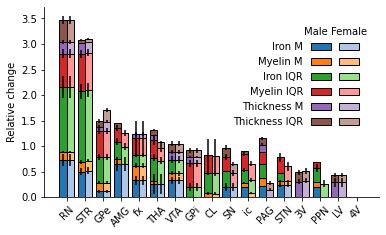

In [35]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
# f.savefig('../figures/figure4-v5.pdf', bbox_inches='tight')

In [13]:
ax[0].get_yticklabels()[0].get_text()

'0.0'

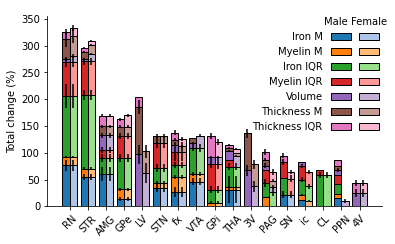

In [7]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'volume_volume', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Total change (%)')
ax[0].set_yticks(np.arange(0,4,.5))
ax[0].set_yticklabels((np.arange(0,4,.5)*100).astype(int))

# custom legend 
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,13,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,15,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Volume', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
                   bbox_to_anchor=(.55, .6, 0.5, 0.5))
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
# print([x.get_text() for x in ax[0].get_yticklabels()])
f.savefig('../figures/figure4-v6-massp2.pdf', bbox_inches='tight')

## Correlation matrix

In [59]:
final_table_proportional2 = final_table_proportional.groupby(level=0).mean()
final_table_proportional2 = final_table_proportional2[['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr', 'volume_volume', 'thickness_median', 'thickness_iqr']]
# final_table_proportional2 = final_table_proportional2.rename(index={'LVENT':'VENTL'}).sort_index()

Text(24.0, 0.5, '')

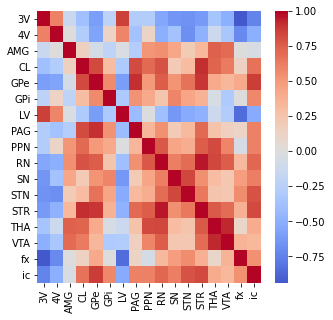

In [41]:
f, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')

In [63]:
from matplotlib.font_manager import findfont, FontProperties


In [64]:
matplotlib.rcParams['font.family']
findfont(FontProperties(family=['sans-serif']))

'/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

Text(373.36363636363626, 0.5, '')

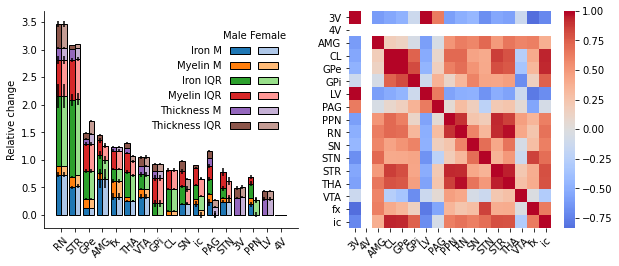

In [38]:
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,2, figsize=(10,4))
#ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
    errbar = msers[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white')
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)            

sns.despine()


sns.heatmap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# f.savefig('../figures/figure3v2.pdf', bbox_inches='tight')

## Dendrogram

,iron_median,iron_iqr,myelin_median,myelin_iqr,volume_volume
ROI,,,,,
3V,0.000,0.0000,0.0000,0.0000,0.5235
4V,0.000,0.0000,0.0000,0.0000,0.2520
AMG,0.600,0.3030,0.0000,0.1460,0.2750
CL,0.000,0.5830,0.0000,0.0440,0.0000
GPe,0.142,0.5800,0.1790,0.4150,0.0000
GPi,0.000,0.2410,0.0685,0.4840,0.1200
LV,0.000,0.0000,0.0000,0.0000,0.7925
PAG,0.000,0.2720,0.0860,0.1205,0.0820
PPN,0.079,0.0985,0.0330,0.0820,0.0945


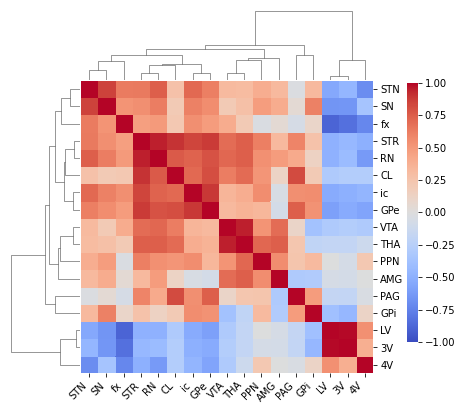

In [64]:
#f, ax = plt.subplots(1,1, figsize=(6,3.5))
# g = sns.clustermap(final_table_proportional2.loc[final_table_proportional2.index != '4V'].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
#                    figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))

#g = sns.clustermap(final_table_proportional2[['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr', 'volume_volume']].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
#                   figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))

g = sns.clustermap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, vmin=-1, 
                   figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='k', ha='right')
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()

plt.gcf().savefig('../figures/figure5v5-massp2.pdf', bbox_inches='tight')

## Combined stacked bars & dendogram

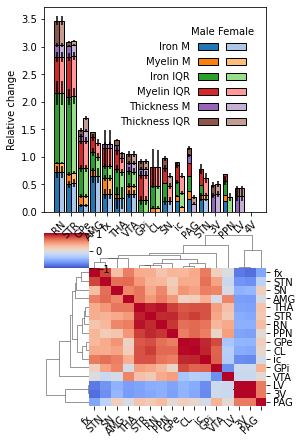

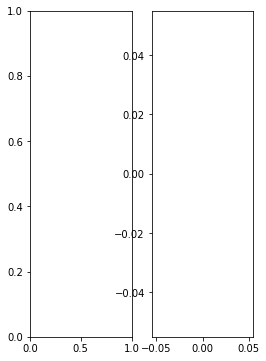

In [66]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)


#f, ax = plt.subplots(1,1, figsize=(6,3.5))
g = sns.clustermap(final_table_proportional2.loc[final_table_proportional2.index != '4V'].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
                   figsize=(4,6), xticklabels=1)#, cbar_pos=(0.95, 0.2, 0.025, 0.6)) #, figsize=(6,6))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='k', ha='right')
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()
g.gs.update(top=.45, bottom=0.05)


###
f, ax = plt.subplots(1,2, figsize=(4,6))
ax = [ax]

gs2 = matplotlib.gridspec.GridSpec(1,1, bottom=0.5)
# create axes within this new gridspec
ax = [g.fig.add_subplot(gs2[0])]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

# sns.despine()
# f.savefig('../figures/figure4-v5.pdf', bbox_inches='tight')

In [53]:
g.show()

AttributeError: 'ClusterGrid' object has no attribute 'show'

## old stuff

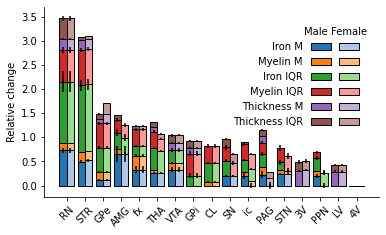

In [5]:
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
    errbar = msers[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
f.savefig('../figures/figure4-v4.pdf', bbox_inches='tight')